# Demo: myslim
TF-Slim is a lightweight library for defining, training and evaluating complex models in TensorFlow. Components of tf-slim can be freely mixed with native tensorflow. To explore this library we can use the following official resource in GitHub:  [tensorflow-contrib-slim](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/slim) and [models-research-slim](https://github.com/tensorflow/models/tree/master/research/slim).

## Why TF-Slim?

TF-Slim is a library that makes building, training and evaluation neural
networks simple:

* Allows the user to define models much more compactly by eliminating
boilerplate code. This is accomplished through the use of
[argument scoping](https://www.tensorflow.org/code/tensorflow/contrib/framework/python/ops/arg_scope.py)
and numerous high level
[layers](https://www.tensorflow.org/code/tensorflow/contrib/layers/python/layers/layers.py)
and
[variables](https://www.tensorflow.org/code/tensorflow/contrib/framework/python/ops/variables.py).
These tools increase readability and maintainability, reduce the likelihood
of an error from copy-and-pasting hyperparameter values and simplifies
hyperparameter tuning.
* Makes developing models simple by providing commonly used
[regularizers](https://www.tensorflow.org/code/tensorflow/contrib/layers/python/layers/regularizers.py).
* Several widely used computer vision models (e.g., VGG, AlexNet) have been
developed in slim, and are
[available](https://www.tensorflow.org/code/tensorflow/contrib/slim/python/slim/nets/)
to users. These can either be used as black boxes, or can be extended in various
ways, e.g., by adding "multiple heads" to different internal layers.
* Slim makes it easy to extend complex models, and to warm start training
algorithms by using pieces of pre-existing model checkpoints.

## What are the various components of TF-Slim?

TF-Slim is composed of several parts which were design to exist independently.
These include the following main pieces.

* [arg_scope](https://www.tensorflow.org/code/tensorflow/contrib/framework/python/ops/arg_scope.py):
provides a new scope named `arg_scope` that allows a user to define default
arguments for specific operations within that scope.
* [data](https://www.tensorflow.org/code/tensorflow/contrib/slim/python/slim/data/):
contains TF-slim's
[dataset](https://www.tensorflow.org/code/tensorflow/contrib/slim/python/slim/data/dataset.py)
definition,
[data providers](https://www.tensorflow.org/code/tensorflow/contrib/slim/python/slim/data/data_provider.py),
[parallel_reader](https://www.tensorflow.org/code/tensorflow/contrib/slim/python/slim/data/parallel_reader.py),
and
[decoding](https://www.tensorflow.org/code/tensorflow/contrib/slim/python/slim/data/data_decoder.py)
utilities.
* [evaluation](https://www.tensorflow.org/code/tensorflow/contrib/slim/python/slim/evaluation.py):
contains routines for evaluating models.
* [layers](https://www.tensorflow.org/code/tensorflow/contrib/layers/python/layers/layers.py):
contains high level layers for building models using tensorflow.
* [learning](https://www.tensorflow.org/code/tensorflow/contrib/slim/python/slim/learning.py):
contains routines for training models.
* [losses](https://www.tensorflow.org/code/tensorflow/contrib/losses/python/losses/loss_ops.py):
contains commonly used loss functions.
* [metrics](https://www.tensorflow.org/code/tensorflow/contrib/metrics/python/ops/metric_ops.py):
contains popular evaluation metrics.
* [nets](https://www.tensorflow.org/code/tensorflow/contrib/slim/python/slim/nets/):
contains popular network definitions such as
[VGG](https://www.tensorflow.org/code/tensorflow/contrib/slim/python/slim/nets/vgg.py)
and
[AlexNet](https://www.tensorflow.org/code/tensorflow/contrib/slim/python/slim/nets/alexnet.py)
models.
* [queues](https://www.tensorflow.org/code/tensorflow/contrib/slim/python/slim/queues.py):
provides a context manager for easily and safely starting and closing
QueueRunners.
* [regularizers](https://www.tensorflow.org/code/tensorflow/contrib/layers/python/layers/regularizers.py):
contains weight regularizers.
* [variables](https://www.tensorflow.org/code/tensorflow/contrib/framework/python/ops/variables.py):
provides convenience wrappers for variable creation and manipulation.

<a id='toc'></a>
## Table of contents
<a href="#0">0. Before starting the demo</a><br>
<a href="#1">1. Dataset</a><br>
<a href='#1.1'>1.1. Flowers</a><br>
<a href='#1.2'>1.2. Cifar-10</a><br>
<a href='#1.3'>1.3. ImageNet</a><br>
<a href='#2'>2. Network</a><br>
<a href='#2.1'>2.1. CNN</a><br>
<a href='#2.2'>2.2. AlexNet</a><br>
<a href='#2.3'>2.3. VGG-16</a><br>
<a href='#2.4'>2.4. VGG-19</a><br>
<a href='#3'>3. Training</a><br>
<a href='#4'>4. Using pre-trained models</a><br>
<a href='#4.1'>4.1. VGG-16</a><br>

<a id='0'></a>
## 0. Before starting the demo
Since the stable release of TF 1.0, the latest version of slim has been available as `tf.contrib.slim`.
To test that the installation is working, execute the following command; it should run without raising any errors.
```
python -c "import tensorflow.contrib.slim as slim; eval = slim.evaluation.evaluate_once"
```

In [1]:
import tensorflow.contrib.slim as slim
eval = slim.evaluation.evaluate_once

To use TF-Slim for image classification, we also need to get the TF-Slim image models library from [here](https://github.com/tensorflow/models/tree/master/research/slim). Download and put it into a directory called TF_MODELS. Then we change directory to  TF_MODELS/research/slim **before** running this notebook, so that these files are in our python path.
To check we've got these two steps to work, just execute the cell below. If it complains about unknown modules, restart the notebook after moving to the TF-Slim models directory.

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np
import tensorflow as tf
import time

from datasets import dataset_utils

# Main slim library
from tensorflow.contrib import slim

<a id='1'></a>
## 1. Dataset
Reading data with TF-Slim has two main components: A **Dataset** and a **DatasetDataProvider**. The former is a descriptor of a dataset, while the latter performs the actions necessary for actually reading the data.

The **Dataset** object allows us to write **generic** code using the same API, regardless of the data content and encoding type. TF-Slim's Dataset works especially well when the data is stored as a (possibly sharded) **TFRecords** file, where each record contains a tf.train.Example protocol buffer. TF-Slim uses a consistent convention for naming the keys and values inside each Example record.

A **DatasetDataProvider** is a class which actually reads the data from a dataset. It is highly configurable to read the data in various ways that may make a big impact on the **efficiency** of your training process. For example, it can be single or multi-threaded. If your data is sharded across many files, it can read each files serially, or from every file simultaneously.

<a id='1.1'></a>
### 1.1. Flowers Dataset
Download the Flowers Dataset
We've made available a tarball of the Flowers dataset which has already been converted to TFRecord format.

In [3]:
import tensorflow as tf
from datasets import dataset_utils

url = "http://download.tensorflow.org/data/flowers.tar.gz"
flowers_data_dir = '/tmp/flowers'

if not tf.gfile.Exists(flowers_data_dir):
    tf.gfile.MakeDirs(flowers_data_dir)

dataset_utils.download_and_uncompress_tarball(url, flowers_data_dir)

>> Downloading flowers.tar.gz 100.0%
Successfully downloaded flowers.tar.gz 228649660 bytes.


Display some of the data.

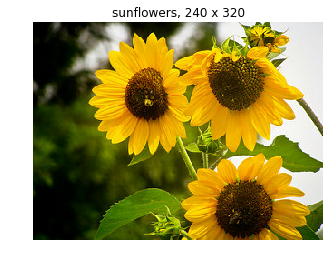

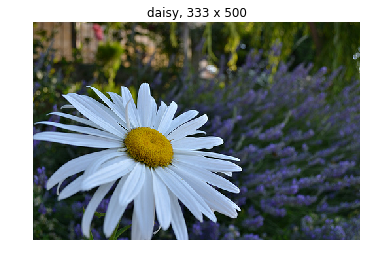

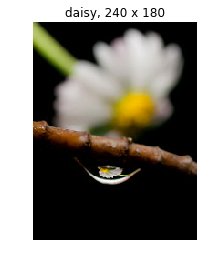

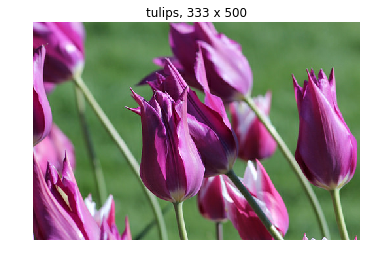

In [4]:
from datasets import flowers
import tensorflow as tf

from tensorflow.contrib import slim

with tf.Graph().as_default(): 
    dataset = flowers.get_split('train', flowers_data_dir)
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32, common_queue_min=1)
    image, label = data_provider.get(['image', 'label'])
    
    with tf.Session() as sess:    
        with slim.queues.QueueRunners(sess):
            for i in range(4):
                np_image, np_label = sess.run([image, label])
                height, width, _ = np_image.shape
                class_name = name = dataset.labels_to_names[np_label]
                
                plt.figure()
                plt.imshow(np_image)
                plt.title('%s, %d x %d' % (name, height, width))
                plt.axis('off')
                plt.show()

<a id='2'></a>
## 2. Network
<a id='2.1'></a>
### 2.1. Convolutional neural nets (CNNs)
In this section, we show how to train an image classifier using a simple CNN.
Define the model.
Below we define a simple CNN. Note that the output layer is linear function - we will apply softmax transformation externally to the model, either in the loss function (for training), or in the prediction function (during testing).

In [5]:
def my_cnn(images, num_classes, is_training):  # is_training is not used...
    with slim.arg_scope([slim.max_pool2d], kernel_size=[3, 3], stride=2):
        net = slim.conv2d(images, 64, [5, 5])
        net = slim.max_pool2d(net)
        net = slim.conv2d(net, 64, [5, 5])
        net = slim.max_pool2d(net)
        net = slim.flatten(net)
        net = slim.fully_connected(net, 192)
        net = slim.fully_connected(net, num_classes, activation_fn=None)       
        return net

<a id='2.2'></a>
### 2.2. AlexNet

Contains a model definition for AlexNet.

This work was first described in: ImageNet Classification with Deep Convolutional Neural Networks, Alex Krizhevsky, Ilya Sutskever and Geoffrey E. Hinton, and later refined in: One weird trick for parallelizing convolutional neural networks, Alex Krizhevsky, 2014.

Here we provide the implementation proposed in "One weird trick" and not "ImageNet Classification", as per the paper, the LRN layers have been removed.

AlexNet version 2. Described in: http://arxiv.org/pdf/1404.5997v2.pdf

Note: All the fully_connected layers have been transformed to conv2d layers. To use in classification mode, resize input to 224x224.

Args:
* inputs: a tensor of size [batch_size, height, width, channels].
* num_classes: number of predicted classes.
* is_training: whether or not the model is being trained.
* dropout_keep_prob: the probability that activations are kept in the dropout layers during training.
* spatial_squeeze: whether or not should squeeze the spatial dimensions of the outputs. Useful to remove unnecessary dimensions for classification.
* scope: Optional scope for the variables.

Returns:
* the last op containing the log predictions and end_points dict.

In [6]:
def alexnet_v2(inputs,
               num_classes=1000,
               is_training=True,
               dropout_keep_prob=0.5,
               spatial_squeeze=True,
               scope='alexnet_v2'):
  with variable_scope.variable_scope(scope, 'alexnet_v2', [inputs]) as sc:
    end_points_collection = sc.original_name_scope + '_end_points'
    # Collect outputs for conv2d, fully_connected and max_pool2d.
    with arg_scope(
        [layers.conv2d, layers_lib.fully_connected, layers_lib.max_pool2d],
        outputs_collections=[end_points_collection]):
      net = layers.conv2d(inputs, 64, [11, 11], 4, padding='VALID', scope='conv1')
      net = layers_lib.max_pool2d(net, [3, 3], 2, scope='pool1')
      net = layers.conv2d(net, 192, [5, 5], scope='conv2')
      net = layers_lib.max_pool2d(net, [3, 3], 2, scope='pool2')
      net = layers.conv2d(net, 384, [3, 3], scope='conv3')
      net = layers.conv2d(net, 384, [3, 3], scope='conv4')
      net = layers.conv2d(net, 256, [3, 3], scope='conv5')
      net = layers_lib.max_pool2d(net, [3, 3], 2, scope='pool5')

      # Use conv2d instead of fully_connected layers.
      with arg_scope(
          [layers.conv2d],
          weights_initializer=trunc_normal(0.005),
          biases_initializer=init_ops.constant_initializer(0.1)):
        net = layers.conv2d(net, 4096, [5, 5], padding='VALID', scope='fc6')
        net = layers_lib.dropout(net, dropout_keep_prob, is_training=is_training, scope='dropout6')
        net = layers.conv2d(net, 4096, [1, 1], scope='fc7')
        net = layers_lib.dropout(net, dropout_keep_prob, is_training=is_training, scope='dropout7')
        net = layers.conv2d(net, num_classes, [1, 1], activation_fn=None, normalizer_fn=None,
                            biases_initializer=init_ops.zeros_initializer(), scope='fc8')

      # Convert end_points_collection into a end_point dict.
      end_points = utils.convert_collection_to_dict(end_points_collection)
      if spatial_squeeze:
        net = array_ops.squeeze(net, [1, 2], name='fc8/squeezed')
        end_points[sc.name + '/fc8'] = net
      return net, end_points

<a id='2.3'></a>
### 2.3. VGG-16
Contains model definitions for versions of the Oxford VGG network. These model definitions were introduced in the following technical report: Very Deep Convolutional Networks For Large-Scale Image Recognition, Karen Simonyan and Andrew Zisserman, arXiv technical report, 2015.
  
PDF: http://arxiv.org/pdf/1409.1556.pdf

ILSVRC 2014 Slides: http://www.robots.ox.ac.uk/~karen/pdf/ILSVRC_2014.pdf, CC-BY-4.0

More information can be obtained from the VGG website: www.robots.ox.ac.uk/~vgg/research/very_deep/

Oxford Net VGG 16-Layers version D Example. VGG-16 use the image size 224 (default).

Note: All the fully_connected layers have been transformed to conv2d layers. To use in classification mode, resize input to 224x224.

Args:

* inputs: a tensor of size [batch_size, height, width, channels].

* num_classes: number of predicted classes.

* is_training: whether or not the model is being trained.

* dropout_keep_prob: the probability that activations are kept in the dropout layers during training.

* spatial_squeeze: whether or not should squeeze the spatial dimensions of the outputs. Useful to remove unnecessary dimensions for classification.

* scope: Optional scope for the variables.

Returns:

* the last op containing the log predictions and end_points dict.

In [7]:
def vgg_16(inputs,
           num_classes=1000,
           is_training=True,
           dropout_keep_prob=0.5,
           spatial_squeeze=True,
           scope='vgg_16'):
  with variable_scope.variable_scope(scope, 'vgg_16', [inputs]) as sc:
    end_points_collection = sc.original_name_scope + '_end_points'
    # Collect outputs for conv2d, fully_connected and max_pool2d.
    with arg_scope(
        [layers.conv2d, layers_lib.fully_connected, layers_lib.max_pool2d],
        outputs_collections=end_points_collection):
      net = layers_lib.repeat(
          inputs, 2, layers.conv2d, 64, [3, 3], scope='conv1')
      net = layers_lib.max_pool2d(net, [2, 2], scope='pool1')
      net = layers_lib.repeat(net, 2, layers.conv2d, 128, [3, 3], scope='conv2')
      net = layers_lib.max_pool2d(net, [2, 2], scope='pool2')
      net = layers_lib.repeat(net, 3, layers.conv2d, 256, [3, 3], scope='conv3')
      net = layers_lib.max_pool2d(net, [2, 2], scope='pool3')
      net = layers_lib.repeat(net, 3, layers.conv2d, 512, [3, 3], scope='conv4')
      net = layers_lib.max_pool2d(net, [2, 2], scope='pool4')
      net = layers_lib.repeat(net, 3, layers.conv2d, 512, [3, 3], scope='conv5')
      net = layers_lib.max_pool2d(net, [2, 2], scope='pool5')
      # Use conv2d instead of fully_connected layers.
      net = layers.conv2d(net, 4096, [7, 7], padding='VALID', scope='fc6')
      net = layers_lib.dropout(
          net, dropout_keep_prob, is_training=is_training, scope='dropout6')
      net = layers.conv2d(net, 4096, [1, 1], scope='fc7')
      net = layers_lib.dropout(
          net, dropout_keep_prob, is_training=is_training, scope='dropout7')
      net = layers.conv2d(
          net,
          num_classes, [1, 1],
          activation_fn=None,
          normalizer_fn=None,
          scope='fc8')
      # Convert end_points_collection into a end_point dict.
      end_points = utils.convert_collection_to_dict(end_points_collection)
      if spatial_squeeze:
        net = array_ops.squeeze(net, [1, 2], name='fc8/squeezed')
        end_points[sc.name + '/fc8'] = net
      return net, end_points

<a id='2.4'></a>
### 2.4. VGG-19
Oxford Net VGG 19-Layers version E Example. VGG-19 use the image size 224 (default).

Note: All the fully_connected layers have been transformed to conv2d layers. To use in classification mode, resize input to 224x224.

Args:
* inputs: a tensor of size [batch_size, height, width, channels].
* num_classes: number of predicted classes.
* is_training: whether or not the model is being trained.
* dropout_keep_prob: the probability that activations are kept in the dropout layers during training.
* spatial_squeeze: whether or not should squeeze the spatial dimensions of the outputs. Useful to remove unnecessary dimensions for classification.
* scope: Optional scope for the variables.

Returns:
* the last op containing the log predictions and end_points dict.

In [8]:
def vgg_19(inputs,
           num_classes=1000,
           is_training=True,
           dropout_keep_prob=0.5,
           spatial_squeeze=True,
           scope='vgg_19'):
  with variable_scope.variable_scope(scope, 'vgg_19', [inputs]) as sc:
    end_points_collection = sc.name + '_end_points'
    # Collect outputs for conv2d, fully_connected and max_pool2d.
    with arg_scope(
        [layers.conv2d, layers_lib.fully_connected, layers_lib.max_pool2d],
        outputs_collections=end_points_collection):
      net = layers_lib.repeat(
          inputs, 2, layers.conv2d, 64, [3, 3], scope='conv1')
      net = layers_lib.max_pool2d(net, [2, 2], scope='pool1')
      net = layers_lib.repeat(net, 2, layers.conv2d, 128, [3, 3], scope='conv2')
      net = layers_lib.max_pool2d(net, [2, 2], scope='pool2')
      net = layers_lib.repeat(net, 4, layers.conv2d, 256, [3, 3], scope='conv3')
      net = layers_lib.max_pool2d(net, [2, 2], scope='pool3')
      net = layers_lib.repeat(net, 4, layers.conv2d, 512, [3, 3], scope='conv4')
      net = layers_lib.max_pool2d(net, [2, 2], scope='pool4')
      net = layers_lib.repeat(net, 4, layers.conv2d, 512, [3, 3], scope='conv5')
      net = layers_lib.max_pool2d(net, [2, 2], scope='pool5')
      # Use conv2d instead of fully_connected layers.
      net = layers.conv2d(net, 4096, [7, 7], padding='VALID', scope='fc6')
      net = layers_lib.dropout(
          net, dropout_keep_prob, is_training=is_training, scope='dropout6')
      net = layers.conv2d(net, 4096, [1, 1], scope='fc7')
      net = layers_lib.dropout(
          net, dropout_keep_prob, is_training=is_training, scope='dropout7')
      net = layers.conv2d(
          net,
          num_classes, [1, 1],
          activation_fn=None,
          normalizer_fn=None,
          scope='fc8')
      # Convert end_points_collection into a end_point dict.
      end_points = utils.convert_collection_to_dict(end_points_collection)
      if spatial_squeeze:
        net = array_ops.squeeze(net, [1, 2], name='fc8/squeezed')
        end_points[sc.name + '/fc8'] = net
      return net, end_points

Apply the model to some randomly generated images.

In [9]:
import tensorflow as tf

with tf.Graph().as_default():
    # The model can handle any input size because the first layer is convolutional.
    # The size of the model is determined when image_node is first passed into the my_cnn function.
    # Once the variables are initialized, the size of all the weight matrices is fixed.
    # Because of the fully connected layers, this means that all subsequent images must have the same
    # input size as the first image.
    batch_size, height, width, channels = 3, 28, 28, 3
    images = tf.random_uniform([batch_size, height, width, channels], maxval=1)
    
    # Create the model.
    num_classes = 10
    logits = my_cnn(images, num_classes, is_training=True)
    probabilities = tf.nn.softmax(logits)
  
    # Initialize all the variables (including parameters) randomly.
    init_op = tf.global_variables_initializer()
  
    with tf.Session() as sess:
        # Run the init_op, evaluate the model outputs and print the results:
        sess.run(init_op)
        probabilities = sess.run(probabilities)
        
print('Probabilities Shape:')
print(probabilities.shape)  # batch_size x num_classes 

print('\nProbabilities:')
print(probabilities)

print('\nSumming across all classes (Should equal 1):')
print(np.sum(probabilities, 1)) # Each row sums to 1

Probabilities Shape:
(3, 10)

Probabilities:
[[ 0.10770308  0.13447553  0.05833435  0.11566805  0.09518848  0.09683248
   0.10113112  0.10264358  0.09398246  0.09404081]
 [ 0.10314398  0.13427424  0.06136745  0.11356231  0.09666798  0.09041006
   0.10377095  0.09667141  0.09746147  0.10267016]
 [ 0.10847357  0.14338177  0.06319927  0.11472426  0.0947717   0.08978523
   0.09901199  0.09879292  0.09247547  0.09538387]]

Summing across all classes (Should equal 1):
[ 0.99999994  1.          1.        ]


<a id='3'></a>
## 3. Training
Train the model on the Flowers dataset.
Before starting, make sure you've run the code to Download the Flowers dataset. Now, we'll get a sense of what it looks like to use TF-Slim's training functions found in learning.py. First, we'll create a function, load_batch, that loads batches of dataset from a dataset. Next, we'll train a model for a single step (just to demonstrate the API), and evaluate the results.

In [10]:
from preprocessing import inception_preprocessing
import tensorflow as tf

from tensorflow.contrib import slim


def load_batch(dataset, batch_size=32, height=299, width=299, is_training=False):
    """Loads a single batch of data.
    
    Args:
      dataset: The dataset to load.
      batch_size: The number of images in the batch.
      height: The size of each image after preprocessing.
      width: The size of each image after preprocessing.
      is_training: Whether or not we're currently training or evaluating.
    
    Returns:
      images: A Tensor of size [batch_size, height, width, 3], image samples that have been preprocessed.
      images_raw: A Tensor of size [batch_size, height, width, 3], image samples that can be used for visualization.
      labels: A Tensor of size [batch_size], whose values range between 0 and dataset.num_classes.
    """
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32,
        common_queue_min=8)
    image_raw, label = data_provider.get(['image', 'label'])
    
    # Preprocess image for usage by Inception.
    image = inception_preprocessing.preprocess_image(image_raw, height, width, is_training=is_training)
    
    # Preprocess the image for display purposes.
    image_raw = tf.expand_dims(image_raw, 0)
    image_raw = tf.image.resize_images(image_raw, [height, width])
    image_raw = tf.squeeze(image_raw)

    # Batch it up.
    images, images_raw, labels = tf.train.batch(
          [image, image_raw, label],
          batch_size=batch_size,
          num_threads=1,
          capacity=2 * batch_size)
    
    return images, images_raw, labels

In [11]:
from datasets import flowers

# This might take a few minutes.
train_dir = '/tmp/tfslim_model/'
print('Will save model to %s' % train_dir)

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)

    dataset = flowers.get_split('train', flowers_data_dir)
    images, _, labels = load_batch(dataset)
  
    # Create the model:
    logits = my_cnn(images, num_classes=dataset.num_classes, is_training=True)
 
    # Specify the loss function:
    one_hot_labels = slim.one_hot_encoding(labels, dataset.num_classes)
    tf.losses.softmax_cross_entropy(one_hot_labels, logits)
    total_loss = tf.losses.get_total_loss()

    # Create some summaries to visualize the training process:
    tf.summary.scalar('losses/Total_Loss', total_loss)
  
    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    train_op = slim.learning.create_train_op(total_loss, optimizer)

    # Run the training:
    final_loss = slim.learning.train(
      train_op,
      logdir=train_dir,
      number_of_steps=1, # For speed, we just do 1 epoch
      save_summaries_secs=1)

    print('Finished training. Final batch loss %d' % final_loss)

Will save model to /tmp/tfslim_model/
INFO:tensorflow:Restoring parameters from /tmp/tfslim_model/model.ckpt-10
INFO:tensorflow:Starting Session.
INFO:tensorflow:Saving checkpoint to path /tmp/tfslim_model/model.ckpt
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:Recording summary at step 10.
INFO:tensorflow:Recording summary at step 10.
INFO:tensorflow:Recording summary at step 10.
INFO:tensorflow:Recording summary at step 10.
INFO:tensorflow:Recording summary at step 10.
INFO:tensorflow:global step 11: loss = 1.6139 (109.425 sec/step)
INFO:tensorflow:Stopping Training.
INFO:tensorflow:Finished training! Saving model to disk.
INFO:tensorfl

<a id='4'></a>
## 4. Using pre-trained models
Neural nets work best when they have many parameters, making them very flexible function approximators. However, this means they must be trained on big datasets. Since this process is slow, we provide various pre-trained models - see the list here.
You can either use these models as-is, or you can perform "surgery" on them, to modify them for some other task. For example, it is common to "chop off" the final pre-softmax layer, and replace it with a new set of weights corresponding to some new set of labels. You can then quickly fine tune the new model on a small new dataset. We illustrate this below, using inception-v1 as the base model. While models like Inception V3 are more powerful, Inception V1 is used for speed purposes.
Take into account that VGG and ResNet final layers have only 1000 outputs rather than 1001. The ImageNet dataset provied has an empty background class which can be used to fine-tune the model to other tasks. VGG and ResNet models provided here don't use that class. We provide two examples of using pretrained models: Inception V1 and VGG-19 models to highlight this difference.

<a id='4.1'></a>
### 4.1. VGG-16
Download the VGG-16 checkpoint.

In [14]:
from datasets import dataset_utils
import tensorflow as tf

url = "http://download.tensorflow.org/models/vgg_16_2016_08_28.tar.gz"
checkpoints_dir = '/tmp/checkpoints'

if not tf.gfile.Exists(checkpoints_dir):
    tf.gfile.MakeDirs(checkpoints_dir)

dataset_utils.download_and_uncompress_tarball(url, checkpoints_dir)

>> Downloading vgg_16_2016_08_28.tar.gz 100.0%
Successfully downloaded vgg_16_2016_08_28.tar.gz 513324920 bytes.


Apply Pre-trained VGG-16 model to Images.
We have to convert each image to the size expected by the model checkpoint. There is no easy way to determine this size from the checkpoint itself. So we use a preprocessor to enforce this. Pay attention to the difference caused by 1000 classes instead of 1001.

INFO:tensorflow:Restoring parameters from /tmp/checkpoints\vgg_16.ckpt


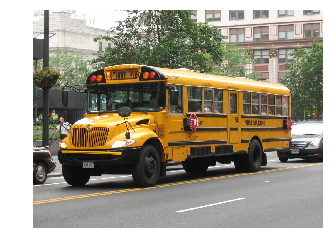

Probability 100.00% => [school bus]
Probability 0.00% => [minibus]
Probability 0.00% => [passenger car, coach, carriage]
Probability 0.00% => [trolleybus, trolley coach, trackless trolley]
Probability 0.00% => [cab, hack, taxi, taxicab]


In [15]:
import numpy as np
import os
import tensorflow as tf

try:
    import urllib2
except ImportError:
    import urllib.request as urllib

from datasets import imagenet
from nets import vgg
from preprocessing import vgg_preprocessing

from tensorflow.contrib import slim

image_size = vgg.vgg_16.default_image_size

with tf.Graph().as_default():
    url = 'https://upload.wikimedia.org/wikipedia/commons/d/d9/First_Student_IC_school_bus_202076.jpg'
    image_string = urllib.urlopen(url).read()
    image = tf.image.decode_jpeg(image_string, channels=3)
    processed_image = vgg_preprocessing.preprocess_image(image, image_size, image_size, is_training=False)
    processed_images  = tf.expand_dims(processed_image, 0)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(vgg.vgg_arg_scope()):
        # 1000 classes instead of 1001.
        logits, _ = vgg.vgg_16(processed_images, num_classes=1000, is_training=False)
    probabilities = tf.nn.softmax(logits)
    
    init_fn = slim.assign_from_checkpoint_fn(
        os.path.join(checkpoints_dir, 'vgg_16.ckpt'),
        slim.get_model_variables('vgg_16'))
    
    with tf.Session() as sess:
        init_fn(sess)
        np_image, probabilities = sess.run([image, probabilities])
        probabilities = probabilities[0, 0:]
        sorted_inds = [i[0] for i in sorted(enumerate(-probabilities), key=lambda x:x[1])]
        
    plt.figure()
    plt.imshow(np_image.astype(np.uint8))
    plt.axis('off')
    plt.show()
    
    names = imagenet.create_readable_names_for_imagenet_labels()
    for i in range(5):
        index = sorted_inds[i]
        # Shift the index of a class name by one. 
        print('Probability %0.2f%% => [%s]' % (probabilities[index] * 100, names[index+1]))

To be continue...

<a href="#toc">Back to top</a><br>